In [1]:
import numpy as np
import pandas as pd
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool
import sys
from functools import partial
import cdpm

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno <= logging.WARNING)
error_handler = logging.StreamHandler(sys.stderr)
error_handler.addFilter(lambda record: record.levelno > logging.WARNING)
root_logger.addHandler(info_handler)
root_logger.addHandler(error_handler)

## Setup the True Parameters /  Simulation Parameters

In [4]:
kharpov = True

In [5]:
if kharpov:
    true_params = {'theta': 1.7680, 
               'pi': -10,
               'phi': -.4,
               'log_scale': np.log(252 * 1.564e-5),
#                 'log_scale' : np.log(.1),
                'log_both': np.log(0.6475) + np.log(252 * 1.564e-5),
               'rho': .5,
              }
else:
#     Daily
     true_params ={'log_both': 0.8819415995231439,
                   'log_scale': 1.7813838683227812,
                   'rho': 0.5294015291756116,
                   'phi': -0.29799406819991614,
#                    'pi': 0.05812774870906164,
                    'pi': 0, 
                   'theta': 0.43003184804533173}
#     Weekly
#     true_params = {'log_both': -0.2768983372209973 + 0.805773558068805,
#                    'log_scale': 0.805773558068805,
#                    'rho': 0.6097218157104826,
#                    'phi': -0.8999999994952989,
#                    # Here I use the daily value.
#                    'pi': -.01,
#                    'theta': 2.6348432313374923}
    
time_dim = 10000
sim_dim = 1000
innov_dim = 250

In [6]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.compute_gamma(**true_params),
     'beta':vl.compute_beta(rho=true_params['rho'], log_scale=true_params['log_scale'],
                            phi=true_params['phi'], pi=true_params['pi'], theta=true_params['theta']),
     'psi':vl.compute_psi(rho=true_params['rho'], log_scale=true_params['log_scale'], phi=true_params['phi'], 
                  theta=true_params['theta']),
      'zeta': 1 - true_params['phi']**2})

In [7]:
def compute_moments(log_both, rho, log_scale, phi, pi, theta):
    
    vol_mean = np.exp(log_both) / (1 - rho)
    vol_var = (2 * np.exp(log_scale) * rho * vol_mean + np.exp(log_scale)**2 * np.exp(log_both - log_scale)) / (1 - rho**2)
    
    psi = vl.compute_psi(rho=rho, log_scale=log_scale, phi=phi, theta=theta)
    beta = vl.compute_beta(rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    gamma = vl.compute_gamma(log_both=log_both, rho=rho, log_scale=log_scale, phi=phi, pi=pi, theta=theta)
    
    return_mean = psi * vol_mean + beta * vol_mean + gamma
    return_var = psi**2 * vol_var + beta**2 * vol_var  + (1 - phi**2) * vol_mean
    
    return {'return_mean': return_mean, 'return_var': return_var, 'vol_mean': vol_mean, 'vol_var': vol_var}

In [8]:
compute_moments(**true_params)

{'return_mean': 0.007673354139615026,
 'return_var': 0.005024656065865211,
 'vol_mean': 0.005103957600000001,
 'vol_var': 4.023225201945602e-05}

In [9]:
vl.compute_gamma(**true_params)

0.012227592917921712

In [10]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

In [11]:
true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5}

In [12]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

## We start by examining the distributions of simulated data

In [13]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

In [14]:
data.corr()

,vol,rtn
vol,1.000000,-0.188293
rtn,-0.188293,1.000000


In [15]:
data.head()

,vol,rtn
2000-01-01,0.006200,0.019070
2000-01-02,0.010335,0.006814
2000-01-03,0.009648,-0.015041
2000-01-04,0.000100,0.022226
2000-01-05,0.000010,0.009490


In [16]:
data.vol.var()

4.300400587704584e-05

In [17]:
init_constants = vl.compute_init_constants(data.vol)

In [18]:
init_constants

{'log_both': -5.991927719734092,
 'log_scale': -5.517339236420315,
 'rho': 0.5168894592029248}

In [19]:
vl.compute_vol_gmm(data.vol, init_constants)

({'log_both': -5.977298866243148,
  'log_scale': -5.5434770574935275,
  'rho': 0.5066544173706016},
            log_both  log_scale       rho
 log_both   0.000649   0.000275 -0.000239
 log_scale  0.000275   0.000490 -0.000064
 rho       -0.000239  -0.000064  0.000194)

In [20]:
omega, omega_cov = vl.estimate_params(data)

In [21]:
omega

{'gamma': 0.012152556779065021,
 'beta': 2.546212063175851,
 'psi': -3.414614103831113,
 'zeta': 0.8379251555852175,
 'log_both': -5.977298866243148,
 'log_scale': -5.5434770574935275,
 'rho': 0.5066544173706016}

In [22]:
omega_cov

,beta,gamma,log_both,log_scale,psi,rho,zeta
beta,0.002158,-5.162942e-06,0.000000,0.000000,-0.001160,0.000000,0.000000
gamma,-0.000005,3.546372e-08,0.000000,0.000000,-0.000002,0.000000,0.000000
log_both,0.000000,0.000000e+00,0.000649,0.000275,0.000000,-0.000239,0.000000
log_scale,0.000000,0.000000e+00,0.000275,0.000490,0.000000,-0.000064,0.000000
psi,-0.001160,-1.693165e-06,0.000000,0.000000,0.017693,0.000000,0.000000
rho,0.000000,0.000000e+00,-0.000239,-0.000064,0.000000,0.000194,0.000000
zeta,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000134


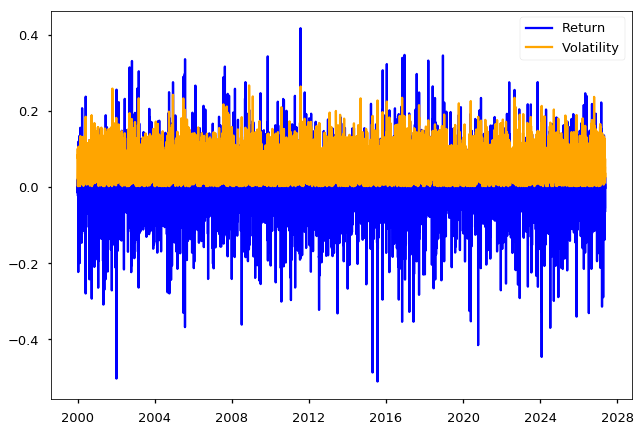

In [23]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return', color='blue')
ax1.plot(data.vol.apply(np.sqrt), label='Volatility', color='orange')

ax1.legend()

In [24]:
data.transform(lambda x: np.sqrt(x) if x.name == 'vol' else x).cov()

,vol,rtn
vol,0.001590,-0.000503
rtn,-0.000503,0.004733


In [25]:
total_true_params

{'theta': 1.768,
 'pi': -10,
 'phi': -0.4,
 'log_scale': -5.536249735335685,
 'log_both': -5.97088622074413,
 'rho': 0.5,
 'gamma': 0.012227592917921712,
 'beta': 2.5479117458224314,
 'psi': -3.440207320203121,
 'zeta': 0.84}

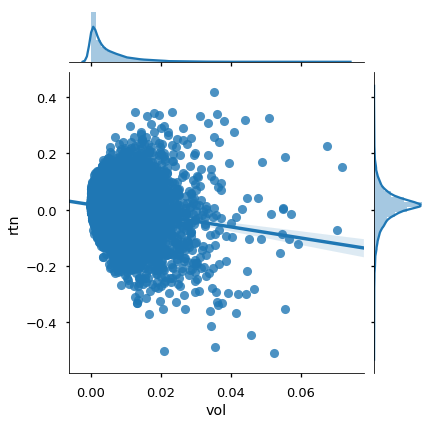

In [26]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [27]:
data.describe()

,vol,rtn
count,10000.000000,10000.000000
mean,0.005173,0.007662
std,0.006558,0.068799
min,0.000010,-0.510712
25%,0.000815,-0.018931
50%,0.002815,0.013487
75%,0.007083,0.039065
max,0.071777,0.418438


## I now estimate all of the parameters

In [28]:
data_arr = [vl.simulate_data(time_dim=time_dim, **true_params)  for _ in tqdm.tnrange(sim_dim)]

In [29]:
def vol_estimator(data):
    return vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [30]:
vol_estimator(data_arr[2])

({'log_both': -5.966769782928821,
  'log_scale': -5.559220948822832,
  'rho': 0.4866969055404066},
            log_both  log_scale       rho
 log_both   0.000696   0.000318 -0.000287
 log_scale  0.000318   0.000514 -0.000096
 rho       -0.000287  -0.000096  0.000226)

In [31]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vol_estimator, data_arr),
                                      total=len(data_arr)))

In [32]:
vol_params = pd.Series(true_params).loc[['log_both', 'log_scale', 'rho']]

In [33]:
ar_stats = [(pd.Series(est[0]) - vol_params) @ np.linalg.pinv(est[1]) @ (pd.Series(est[0]) - vol_params).T 
            for est in est_arr]

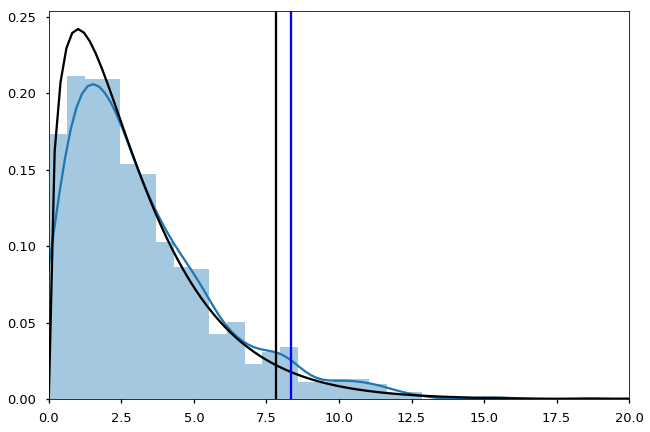

In [34]:
vol_fig, vol_ax = mpl.pyplot.subplots()
sns.distplot(ar_stats, ax=vol_ax)
vol_ax.plot(np.linspace(0, 20, 100), stats.chi2.pdf(np.linspace(0,20,100), df=3), color='black')
vol_ax.set_xlim([0,20])
vol_ax.axvline(stats.chi2.ppf(df=3, q=.95), color='black')
vol_ax.axvline(np.percentile(ar_stats, 95), color='blue')

In [35]:
100 * np.mean(stats.chi2.ppf(df=3, q=.95) < ar_stats)

7.3

In [36]:
t_stats = [(name, (est[0][name] - vol_params[name]) / np.sqrt(est[1].loc[name, name]) )
            for est in est_arr for name in ['rho', 'log_scale', 'log_both']]
t_stats_df = pd.DataFrame.from_records(t_stats).pivot(columns=0, values=1).ffill().bfill().iloc[::3,:]

In [37]:
vl.compute_init_constants(data.vol)

{'log_both': -5.991927719734092,
 'log_scale': -5.517339236420315,
 'rho': 0.5168894592029248}

In [38]:
true_params['log_both']

-5.97088622074413

In [39]:
np.amin([est[0]['log_both'] for est in est_arr])

-6.057785248133501

In [40]:
t_stats_df.describe()

,log_both,log_scale,rho
count,1000.000000,1000.000000,1000.000000
mean,0.003813,-0.219495,-0.077860
std,0.987724,1.023581,1.057275
min,-3.188714,-4.435699,-3.229405
25%,-0.692367,-0.847944,-0.776922
50%,0.022451,-0.165536,-0.080898
75%,0.704450,0.476223,0.616881
max,3.210998,2.831183,3.693758


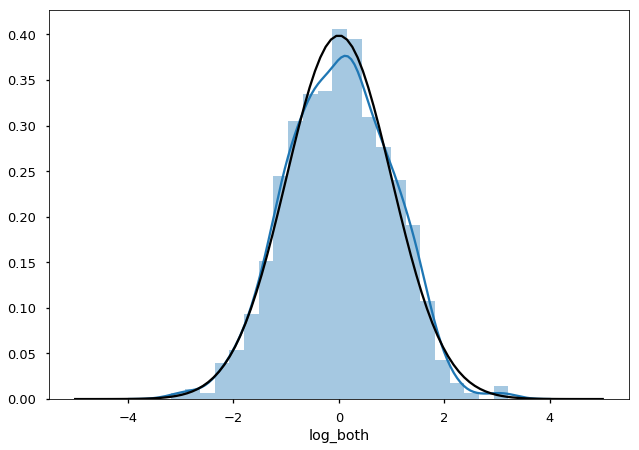

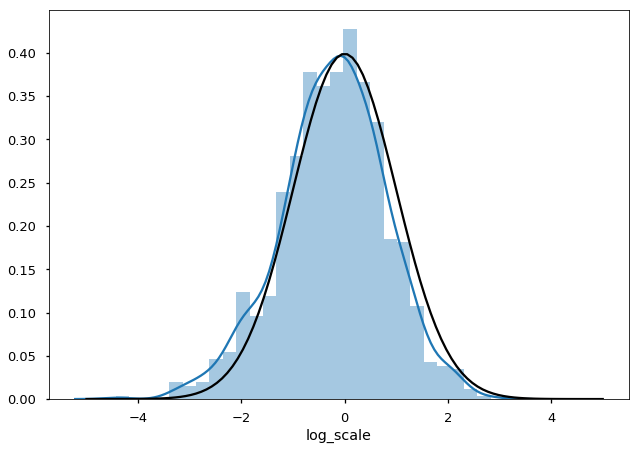

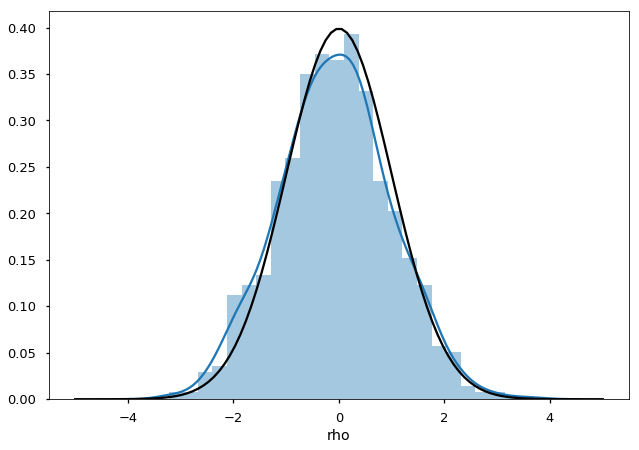

In [41]:
for name, col in t_stats_df.items():
    fig, ax = mpl.pyplot.subplots()
    sns.distplot(col, ax=ax)
    ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')

In [42]:
estimator = partial(vl.estimate_params_strong_id, case=1)

In [43]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(estimator, data_arr),
                                      total=len(data_arr)))

In [44]:
def t_stats(x):
    mean = x.mean()
    cov = x.cov()
        
    return mean  / np.sqrt(np.diag(cov) / data.vol.size)

In [45]:
moment_data = pd.DataFrame([t_stats(vl.vol_moments(data.vol, log_both=true_params['log_both'],
                                                   rho=true_params['rho'], log_scale=true_params['log_scale'])) 
                            for data in tqdm.tqdm_notebook(data_arr)])

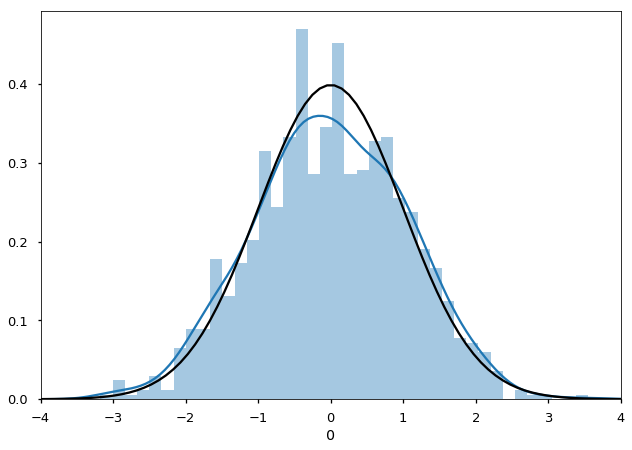

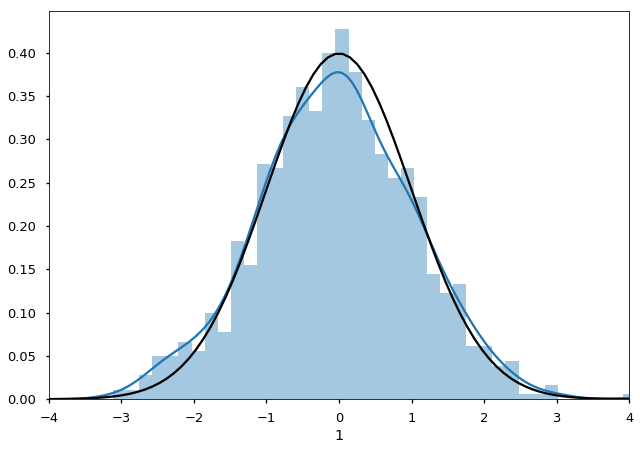

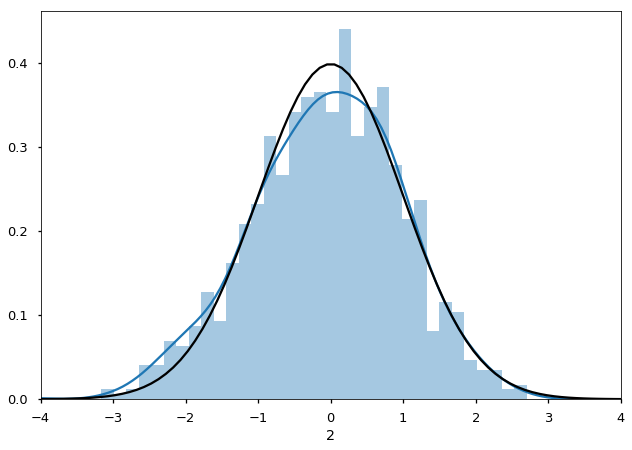

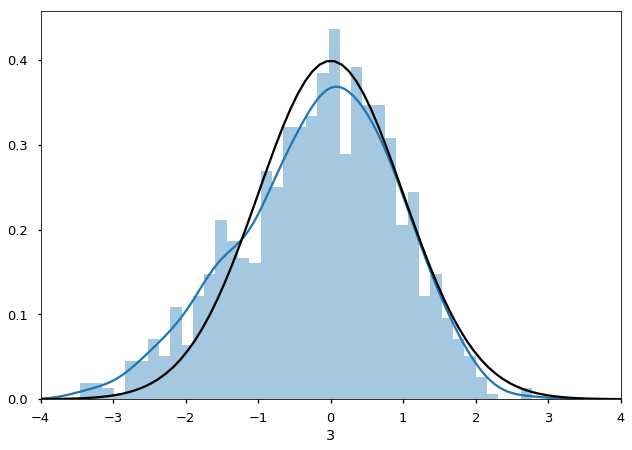

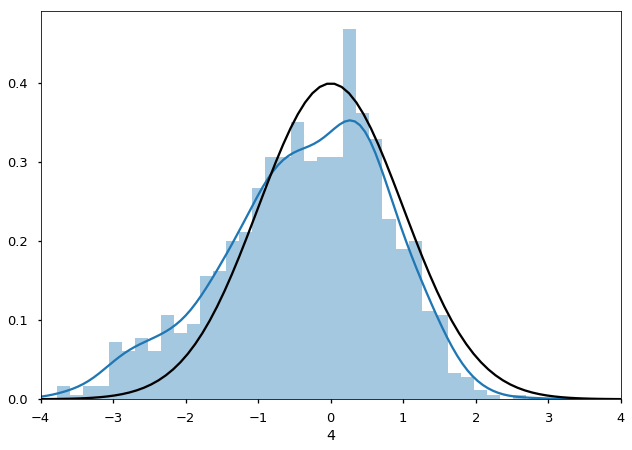

In [46]:
for name, moment in moment_data.items():
    moment_fig, moment_ax = mpl.pyplot.subplots()
    sns.distplot(moment, ax=moment_ax, bins=40)
    moment_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
    moment_ax.set_xlim([-4,4])

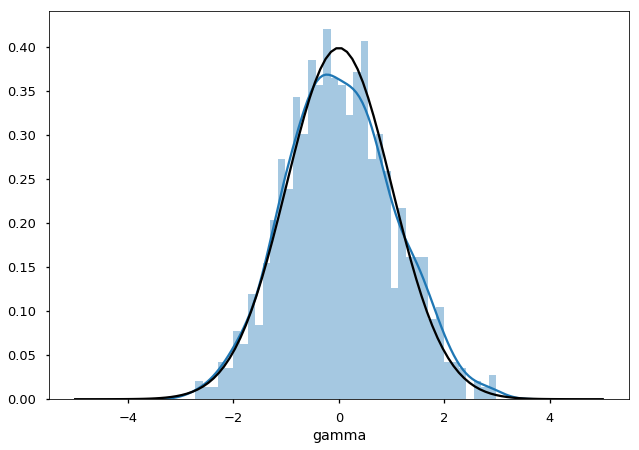

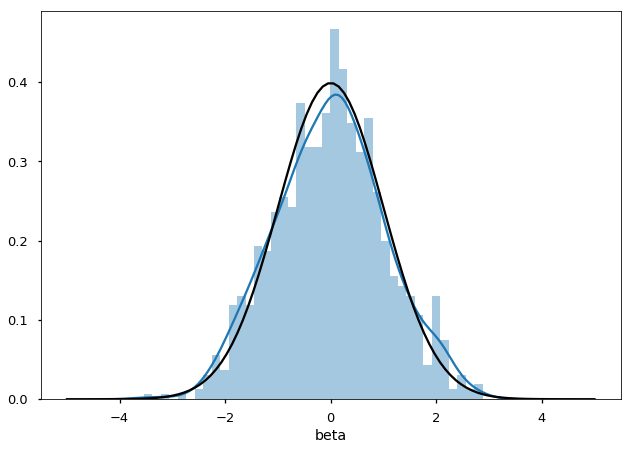

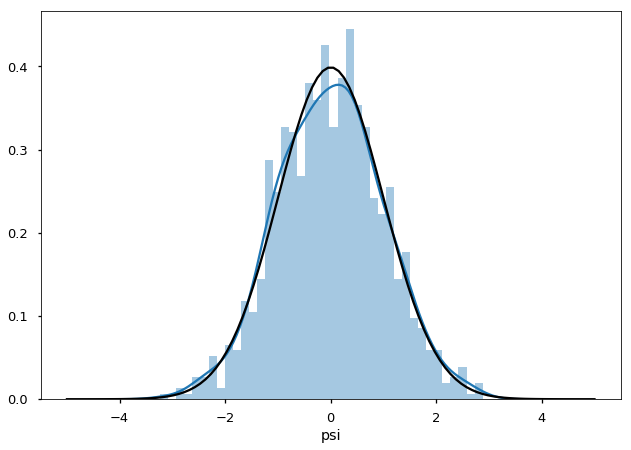

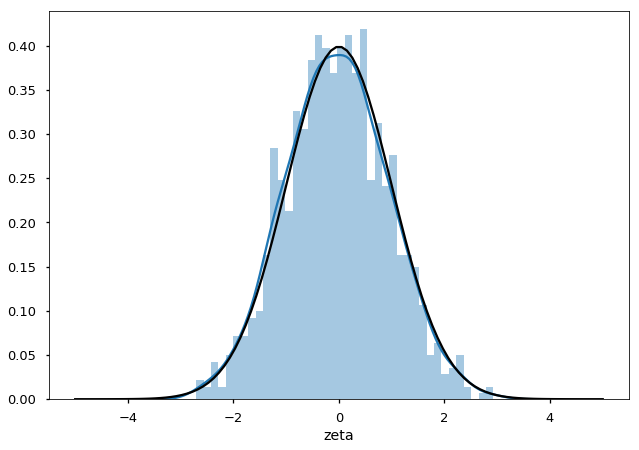

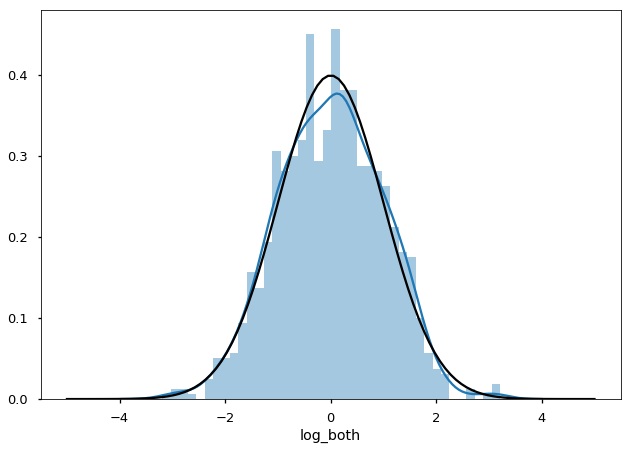

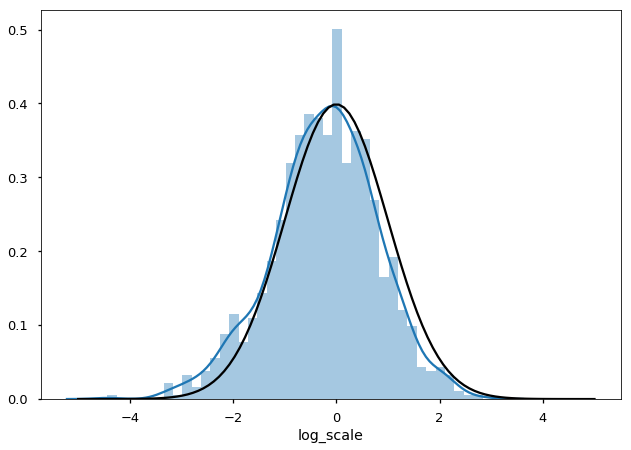

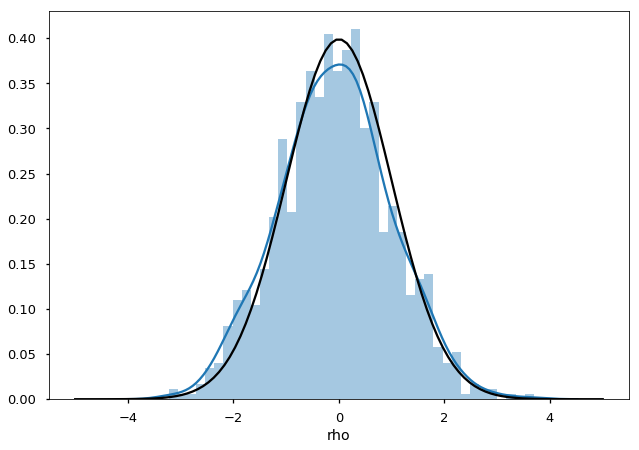

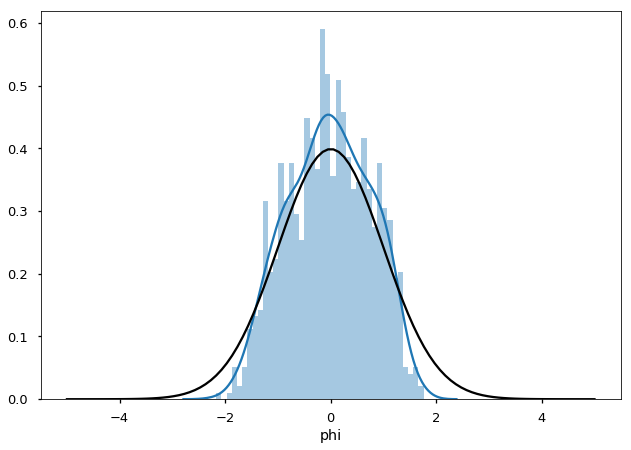

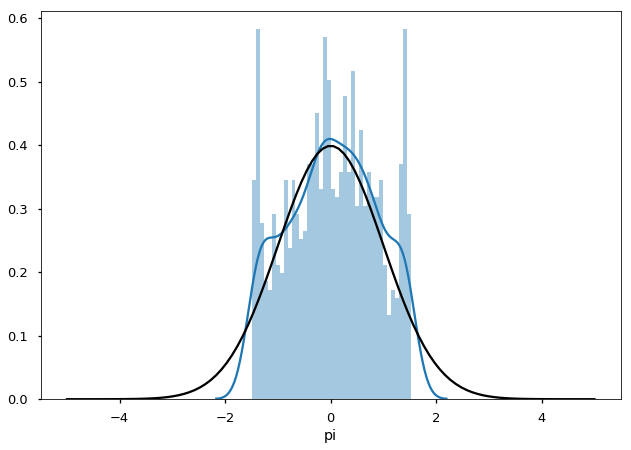

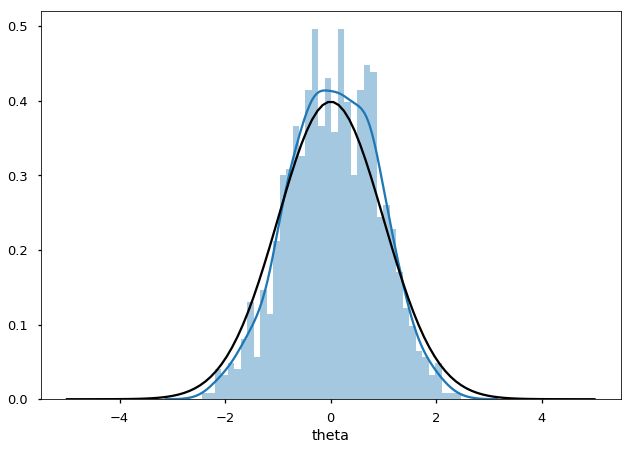

In [47]:
with pd.option_context('mode.use_inf_as_null', True):
    for name in est_arr[0][0].keys():
        fig, ax = mpl.pyplot.subplots()       
        sns.distplot(pd.Series([(est[name] - total_true_params[name]) / np.sqrt(cov.loc[name,name])
                  for est, cov in est_arr]).dropna(), ax=ax, bins=40)
        ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
        ax.set_xlabel(name)
#         if max(ax.get_xlim()) > 20:
#             ax.set_xlim(-20, 20)

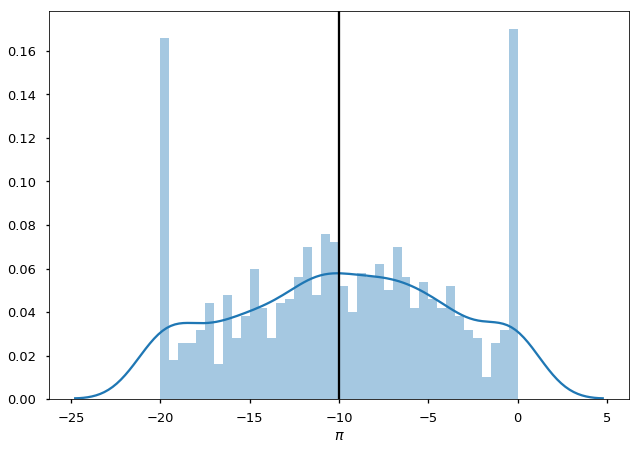

In [48]:
fig, ax = mpl.pyplot.subplots()       
sns.distplot(pd.Series([est['pi'] for est, cov in est_arr]).dropna(), ax=ax, bins=40)
ax.axvline(total_true_params['pi'], color='black')
ax.set_xlabel('$\pi$')
fig.savefig('../doc/figures/pi_est_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
                        frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

# I now compute the robust conditional QLR statistic 

In [ ]:
omega


In [ ]:
true_params

In [ ]:
compute_vals = partial(vl.compute_qlr_reject, true_prices=[true_params['phi'], true_params['pi'], 
                                                           true_params['theta']],
                      innov_dim=50, alpha=None, robust_quantile=True)

In [ ]:
def compute_ar(params, case=1):
    param_est, param_cov = params
    names = vl.compute_names(case)
    omega = {name: val for name, val in param_est.items() if name not in names}
    omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
    true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
    
    return vl._qlr_in(prices=true_prices, omega=omega, omega_cov=omega_cov, case=case)

In [ ]:
param_est, param_cov = est_arr[0]
names = vl.compute_names(1)
omega = {name: val for name, val in param_est.items() if name not in names}
omega_cov = param_cov.query('index not in @names').T.query('index not in @names').T
    
true_prices=[true_params['phi'], true_params['pi'], true_params['theta']]
# data.shape[0] * vl.covariance_kernel(true_prices, true_prices, omega_cov=omega_cov, omega=omega, case=1)
vl.compute_link(prices=true_prices, omega=omega, case=1)

In [ ]:
compute_ar(est_arr[0])

In [ ]:
with Pool(8) as pool:
    ar_results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_ar, est_arr),
                                                          total=len(est_arr)))))

In [ ]:
with pd.option_context('mode.use_inf_as_null', True):
    fig, ax = mpl.pyplot.subplots()       
    sns.distplot(ar_results.dropna(), ax=ax, bins=40)
    ax.plot(np.linspace(0,20,100), stats.chi2.pdf(np.linspace(0,20,100), df=4), color='black')

    ax.set_xlabel('AR Statistic Distribution')
    ax.set_xlim(0, 20)
    ax.axvline(np.percentile(ar_results, q=95), color='red')
    ax.axvline(stats.chi2.ppf(df=4, q=.95), color='green')

In [ ]:
# total=min(50, len(est_arr))
# with Pool(8) as pool:
#     results = pd.DataFrame(np.row_stack(list(tqdm.tqdm_notebook(pool.imap_unordered(compute_vals, 
#                                                                                     est_arr[:total]),
#                                                           total=total))))

In [ ]:
 stats.chi2.ppf(df=4, q=.95)

In [ ]:
100 * np.mean(ar_results > stats.chi2.ppf(df=4, q=.95))

In [ ]:
# results[results <=0] = 0 

In [ ]:
# robust_pit = cdpm.probability_integral_transform(evaluated_data = results.iloc[:,0].to_frame(),
#                                     reference_data=results.iloc[:,1:]).replace(np.inf, 1)

In [ ]:
# standard_pit = stats.chi2.cdf(results.iloc[:,0], df=3)

In [ ]:
# fig, ax = mpl.pyplot.subplots()
# cdpm.pit_plot(standard_pit, ax=ax, color='orange', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='standard')
# cdpm.pit_plot(robust_pit, ax=ax, color='blue', hist_kws={'histtype':'step', 'alpha':1, 'linewidth':3},
#               label='robust')
# ax.legend()
# fig.savefig('../doc/figures/asymptotic_dist_pitop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
#             frameon=False, pad_inches=0, bbox_inches='tight', transparent=True)

In [ ]:
returnval = vl.compute_robust_rejection(est_arr, true_params, innov_dim=innov_dim, alpha=0.05, case=1,
                                        robust_quantile=True)

In [ ]:
returnval.head()

In [ ]:
returnval.head()

In [ ]:
returnval.mean()

In [ ]:
true_params['phi']

In [ ]:
if kharpov:
    filename = '../results/reject_prop_kharpov_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
else:
    filename = '../results/reject_prop_{}_{}_{}.json'.format(innov_dim, true_params['phi'], 
                                                                         time_dim)
    
returnval.to_json(filename)

In [ ]:
returnval.mean()

In [ ]:
returnval.query('robust_qlr_qauntile > 0').mean()

In [ ]:
fig4, ax4 = mpl.pyplot.subplots()
try:
    sns.distplot(returnval.query('robust_qlr_qauntile > 0').robust_qlr_qauntile, 
                 kde_kws={"color": "red", "lw": 3, 'cumulative':True}, ax=ax4,hist=False, 
                 label='Robust Conditional Quantile')
           
except AttributeError:
    pass

sns.distplot(returnval.qlr_stat, hist=False, ax=ax4,kde_kws={"color": "blue", "lw": 3, 'cumulative':True},
      label='QLR Statistic')
ax4.axvline(stats.chi2.ppf(.95, df=3), color='black', label='Standard Quantile')
ax4.axvline(np.percentile(returnval.qlr_stat, 95),  color='Blue', label='Quantile in the data')

xvals = np.linspace(0, 20, 500)
ax4.plot(xvals, [stats.chi2.cdf(x, df=3) for x in xvals], color='green', label='$\chi^2(3)$ distribution')
ax4.set_xlim([0,50])
# ax4.set_ylim([0,.5])
ax4.set_xlabel("")
ax4.legend()
fig4.savefig('../doc/figures/reject_prop_{}_{}.tmp.pdf'.format(innov_dim, true_params['phi']),
            frameon=False, pad_inches=0, bbox_inces='tight', transparent=True)